## FIFA 해외 축구 선수 이적료 예측
### 데이터 불러오기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, skew


from matplotlib.pylab import rcParams   # 그래프 크기를 크게 하는 함수 항상 사용
rcParams['figure.figsize'] = 17,8          # 폰트 크기 크게 조정
rcParams['font.family'] = 'malgun Gothic'   # 한글 폰트(맑은고딕) 사용하기

import warnings
warnings.filterwarnings('ignore')   # 핑크색 warnings들이 안보이게 조절

In [2]:
train = pd.read_csv('FIFA_train.csv')
test = pd.read_csv('FIFA_test.csv')
submission = pd.read_csv('submission.csv')
print(train.shape)
train.head()

(8932, 12)


,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
0,0,L. Messi,31,south america,2021,ST,left,5.0,94,94,4.0,110500000.0
1,3,De Gea,27,europe,2020,GK,right,4.0,91,93,1.0,72000000.0
2,7,L. Suárez,31,south america,2021,ST,right,5.0,91,91,3.0,80000000.0
3,8,Sergio Ramos,32,europe,2020,DF,right,4.0,91,91,3.0,51000000.0
4,9,J. Oblak,25,europe,2021,GK,right,3.0,90,93,1.0,68000000.0


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                8932 non-null   int64  
 1   name              8932 non-null   object 
 2   age               8932 non-null   int64  
 3   continent         8932 non-null   object 
 4   contract_until    8932 non-null   object 
 5   position          8932 non-null   object 
 6   prefer_foot       8932 non-null   object 
 7   reputation        8932 non-null   float64
 8   stat_overall      8932 non-null   int64  
 9   stat_potential    8932 non-null   int64  
 10  stat_skill_moves  8932 non-null   float64
 11  value             8932 non-null   float64
dtypes: float64(3), int64(4), object(5)
memory usage: 837.5+ KB


In [4]:
# contract_util : 계약기간
# reputation : 평판 (높을수록 평판 좋은것)
# stat_overall : 선수 능력치
# stat_potential : 선수 잠재능력
# stat_skill_moves : 선수의 개인기 능력치
# value : FIFA가 선정한 선수의 이적 시장 가격  -> y값

In [5]:
train['contract_until'].unique()  # 계약기간내 일자 표준화 필요

array(['2021', '2020', '2019', '2023', '2022', '2024', 'Jun 30, 2019',
       '2026', 'Dec 31, 2018', '2018', '2025', 'Jun 30, 2020',
       'May 31, 2020', 'May 31, 2019', 'Jan 31, 2019', 'Jan 1, 2019',
       'Jan 12, 2019'], dtype=object)

In [6]:
train['stat_skill_moves'].unique() # 컴럼별 확인하는 것 말고 다른 방법은 없을까?

array([4., 1., 3., 2., 5.])

In [7]:
train['reputation'].unique()

array([5., 4., 3., 1., 2.])

In [8]:
train['stat_overall'].unique()

array([94, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76,
       75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59,
       58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47], dtype=int64)

In [9]:
train['age'].unique()

array([31, 27, 32, 25, 26, 29, 33, 30, 40, 24, 28, 34, 23, 22, 35, 36, 21,
       18, 19, 37, 20, 39, 17, 38, 16], dtype=int64)

In [10]:
train['continent'].unique()

array(['south america', 'europe', 'africa', 'asia', 'oceania'],
      dtype=object)

In [11]:
train['stat_potential'].unique()

array([94, 93, 91, 90, 92, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78,
       77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61,
       60, 59, 58, 57, 56, 55, 54, 53, 52, 50, 48], dtype=int64)

In [12]:
train['position'].unique()         

array(['ST', 'GK', 'DF', 'MF'], dtype=object)

In [13]:
train['prefer_foot'].unique() 

array(['left', 'right'], dtype=object)

In [14]:
train.isna().sum()   # 값이 null이 있는지 확인

id                  0
name                0
age                 0
continent           0
contract_until      0
position            0
prefer_foot         0
reputation          0
stat_overall        0
stat_potential      0
stat_skill_moves    0
value               0
dtype: int64

In [15]:
test.isna().sum()

id                  0
name                0
age                 0
continent           0
contract_until      0
position            0
prefer_foot         0
reputation          0
stat_overall        0
stat_potential      0
stat_skill_moves    0
dtype: int64

In [16]:
train.describe(include = 'all')   # 전체 통계 확인

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves,value
count,8932.000000,8932,8932.000000,8932,8932,8932,8932,8932.000000,8932.000000,8932.000000,8932.000000,8.932000e+03
unique,NaN,8932,NaN,5,17,4,2,NaN,NaN,NaN,NaN,NaN
top,NaN,L. Messi,NaN,europe,2019,MF,right,NaN,NaN,NaN,NaN,NaN
freq,NaN,1,NaN,5322,2366,3428,6837,NaN,NaN,NaN,NaN,NaN
mean,7966.775750,NaN,25.209136,NaN,NaN,NaN,NaN,1.130878,67.091133,71.997201,2.401702,2.778673e+06
std,4844.428521,NaN,4.635515,NaN,NaN,NaN,NaN,0.423792,6.854910,5.988147,0.776048,5.840982e+06
min,0.000000,NaN,16.000000,NaN,NaN,NaN,NaN,1.000000,47.000000,48.000000,1.000000,1.000000e+04
25%,3751.750000,NaN,21.000000,NaN,NaN,NaN,NaN,1.000000,63.000000,68.000000,2.000000,3.750000e+05
50%,7696.500000,NaN,25.000000,NaN,NaN,NaN,NaN,1.000000,67.000000,72.000000,2.000000,8.250000e+05
75%,12082.250000,NaN,28.000000,NaN,NaN,NaN,NaN,1.000000,72.000000,76.000000,3.000000,2.600000e+06


In [17]:
print(test.shape)
test.head()

(3828, 11)


,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves
0,1,Cristiano Ronaldo,33,europe,2022,ST,right,5.0,94,94,5.0
1,2,Neymar Jr,26,south america,2022,ST,right,5.0,92,93,5.0
2,4,K. De Bruyne,27,europe,2023,MF,right,4.0,91,92,4.0
3,5,E. Hazard,27,europe,2020,ST,right,4.0,91,91,4.0
4,6,L. Modrić,32,europe,2020,MF,right,4.0,91,91,4.0


In [18]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3828 entries, 0 to 3827
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                3828 non-null   int64  
 1   name              3828 non-null   object 
 2   age               3828 non-null   int64  
 3   continent         3828 non-null   object 
 4   contract_until    3828 non-null   object 
 5   position          3828 non-null   object 
 6   prefer_foot       3828 non-null   object 
 7   reputation        3828 non-null   float64
 8   stat_overall      3828 non-null   int64  
 9   stat_potential    3828 non-null   int64  
 10  stat_skill_moves  3828 non-null   float64
dtypes: float64(2), int64(4), object(5)
memory usage: 329.1+ KB


In [19]:
test.describe(include = 'all')

,id,name,age,continent,contract_until,position,prefer_foot,reputation,stat_overall,stat_potential,stat_skill_moves
count,3828.000000,3828,3828.000000,3828,3828,3828,3828,3828.000000,3828.000000,3828.000000,3828.000000
unique,NaN,3828,NaN,5,18,4,2,NaN,NaN,NaN,NaN
top,NaN,Cristiano Ronaldo,NaN,europe,2021,MF,right,NaN,NaN,NaN,NaN
freq,NaN,1,NaN,2269,985,1431,2915,NaN,NaN,NaN,NaN
mean,7846.258098,NaN,25.297806,NaN,NaN,NaN,NaN,1.143939,67.336991,72.107628,2.414838
std,4870.339361,NaN,4.628236,NaN,NaN,NaN,NaN,0.448465,6.908814,6.133428,0.781153
min,1.000000,NaN,16.000000,NaN,NaN,NaN,NaN,1.000000,47.000000,52.000000,1.000000
25%,3466.250000,NaN,22.000000,NaN,NaN,NaN,NaN,1.000000,63.000000,68.000000,2.000000
50%,7643.500000,NaN,25.000000,NaN,NaN,NaN,NaN,1.000000,67.000000,72.000000,2.000000
75%,11967.000000,NaN,29.000000,NaN,NaN,NaN,NaN,1.000000,72.000000,76.000000,3.000000


###  EDA

<AxesSubplot:xlabel='value', ylabel='Density'>

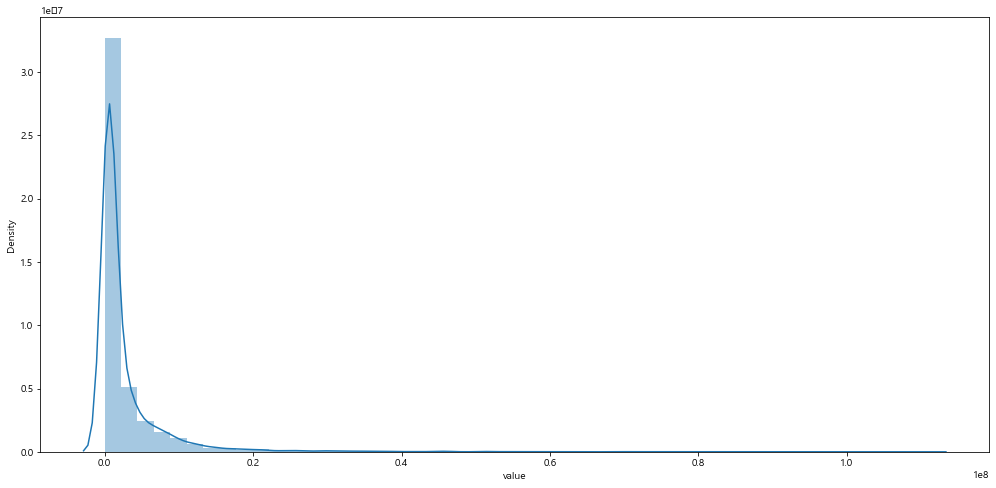

In [20]:
sns.distplot(train.value) 

<AxesSubplot:xlabel='continent', ylabel='count'>

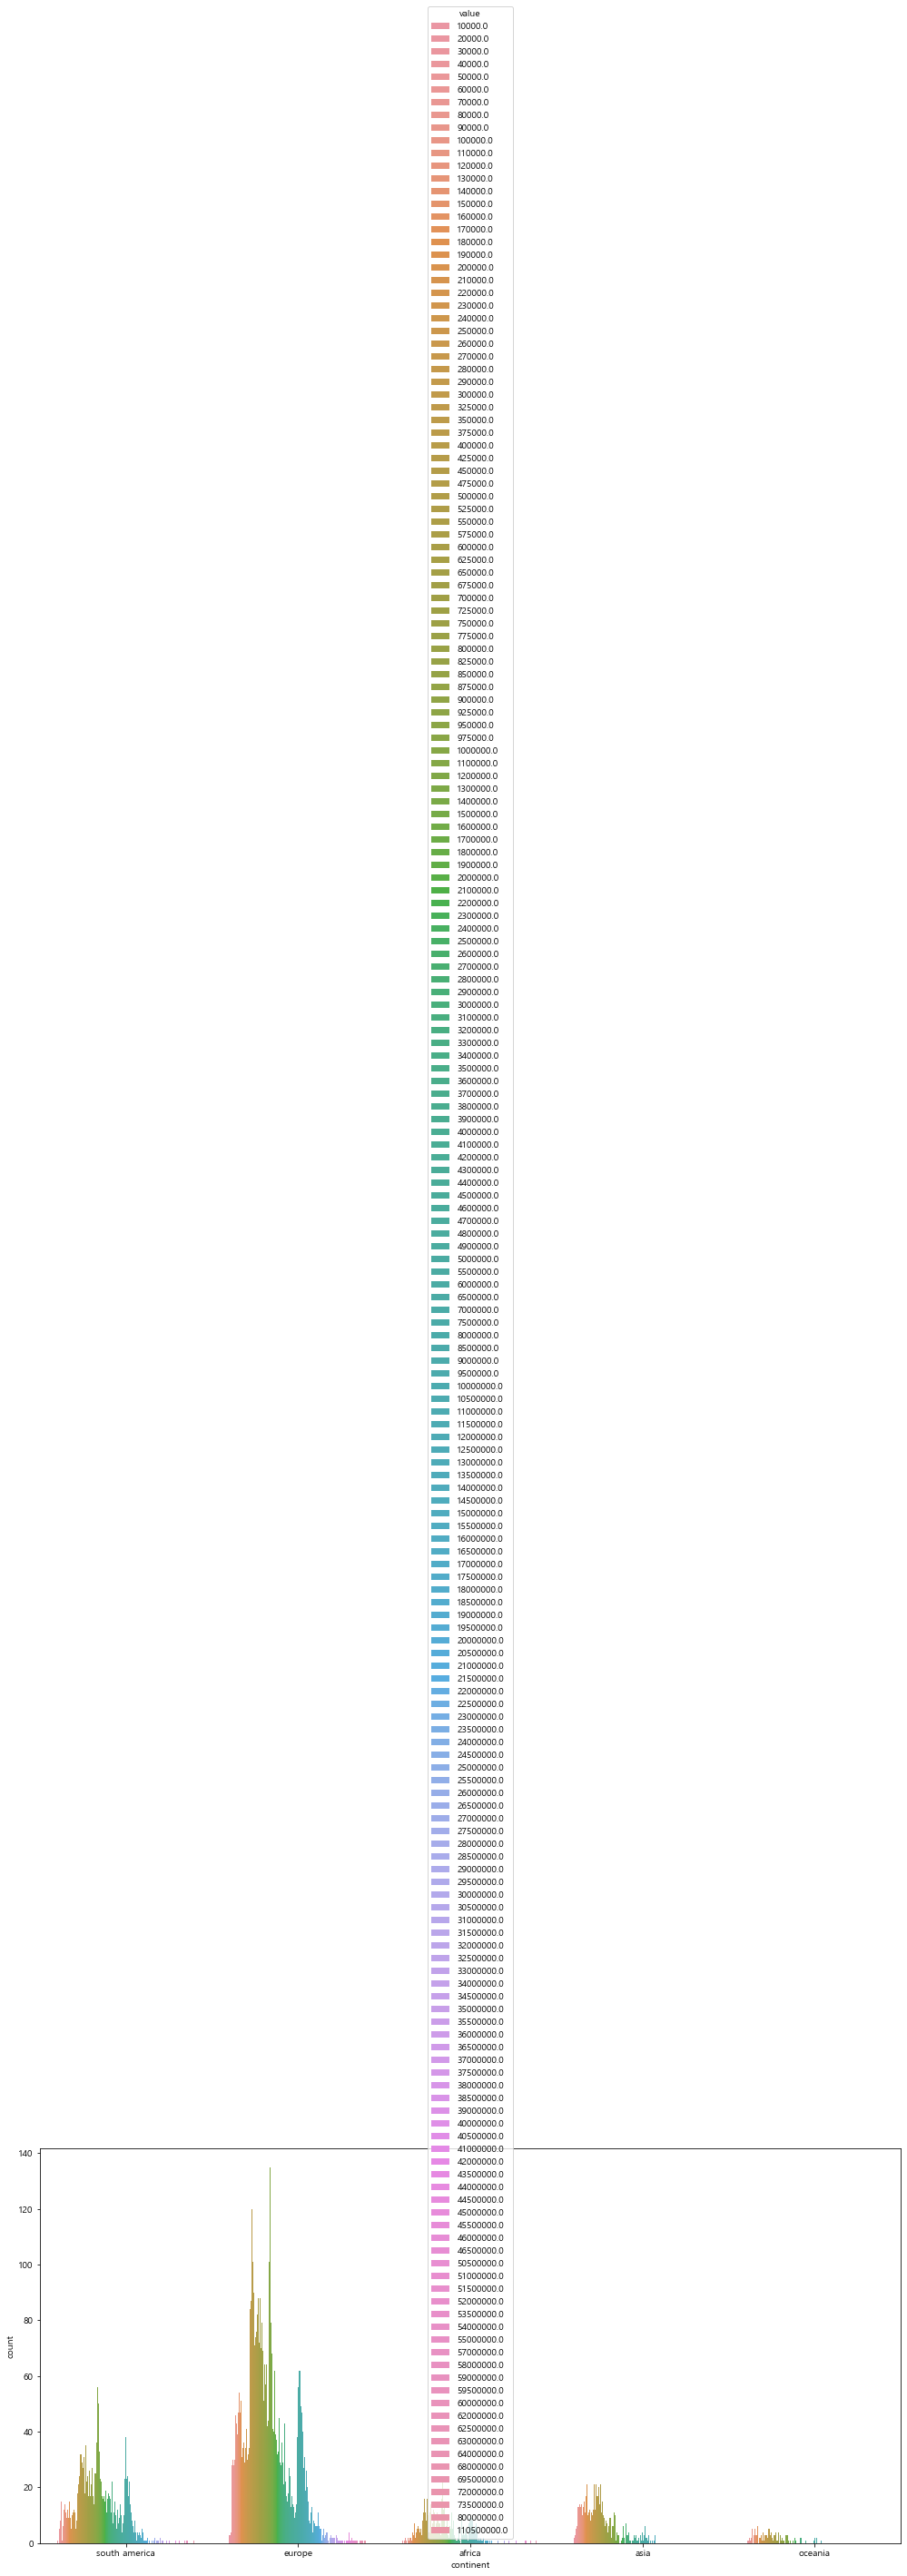

In [21]:
sns.countplot(data=train, x="continent", hue="value") # 사우스아프리카와 유럽에 고연봉자가 많고 그외는 없음

In [22]:
C1 = train[train.continent == 'south america'].value.mean()  # 지역별 연봉 평균 구하기
C2 = train[train.continent == 'europe'].value.mean()
C3 = train[train.continent == 'africa'].value.mean()
C4 = train[train.continent == 'asia'].value.mean()
C5 = train[train.continent == 'oceania'].value.mean()
print("%.2f, %.2f, %.2f, %.2f, %.2f" %(C1, C2, C3, C4, C5))   # 결과 : south > europe > africa > asia > oceania

3183204.46, 2928124.77, 2972246.88, 1035146.12, 822542.86


In [23]:
train.continent.value_counts()

europe           5322
south america    1927
asia              787
africa            721
oceania           175
Name: continent, dtype: int64

In [24]:
# 지역별 평균 이상 연봉인 사람 비율
C1_mean_rate =  (train[(train.continent == 'south america') & (train.value >= C1)].continent.count()) / 1927 * 100
C2_mean_rate =  (train[(train.continent == 'europe') & (train.value >= C2)].continent.count()) / 5322 * 100
C3_mean_rate =  (train[(train.continent == 'africa') & (train.value >= C1)].continent.count()) / 721 * 100
C4_mean_rate =  (train[(train.continent == 'asia') & (train.value >= C2)].continent.count()) / 787 * 100
C5_mean_rate =  (train[(train.continent == 'oceania') & (train.value >= C2)].continent.count()) / 175 * 100
print("%.2f%%, %.2f%%, %.2f%%, %.2f%%, %.2f%%" %(C1_mean_rate, C2_mean_rate, C3_mean_rate, C4_mean_rate, C5_mean_rate))
# 지역별 평균 연봉 이상 비율이 높은순 : south > africa > europe > asia > oceania

26.93%, 23.24%, 26.21%, 9.53%, 6.86%


<AxesSubplot:xlabel='position', ylabel='count'>

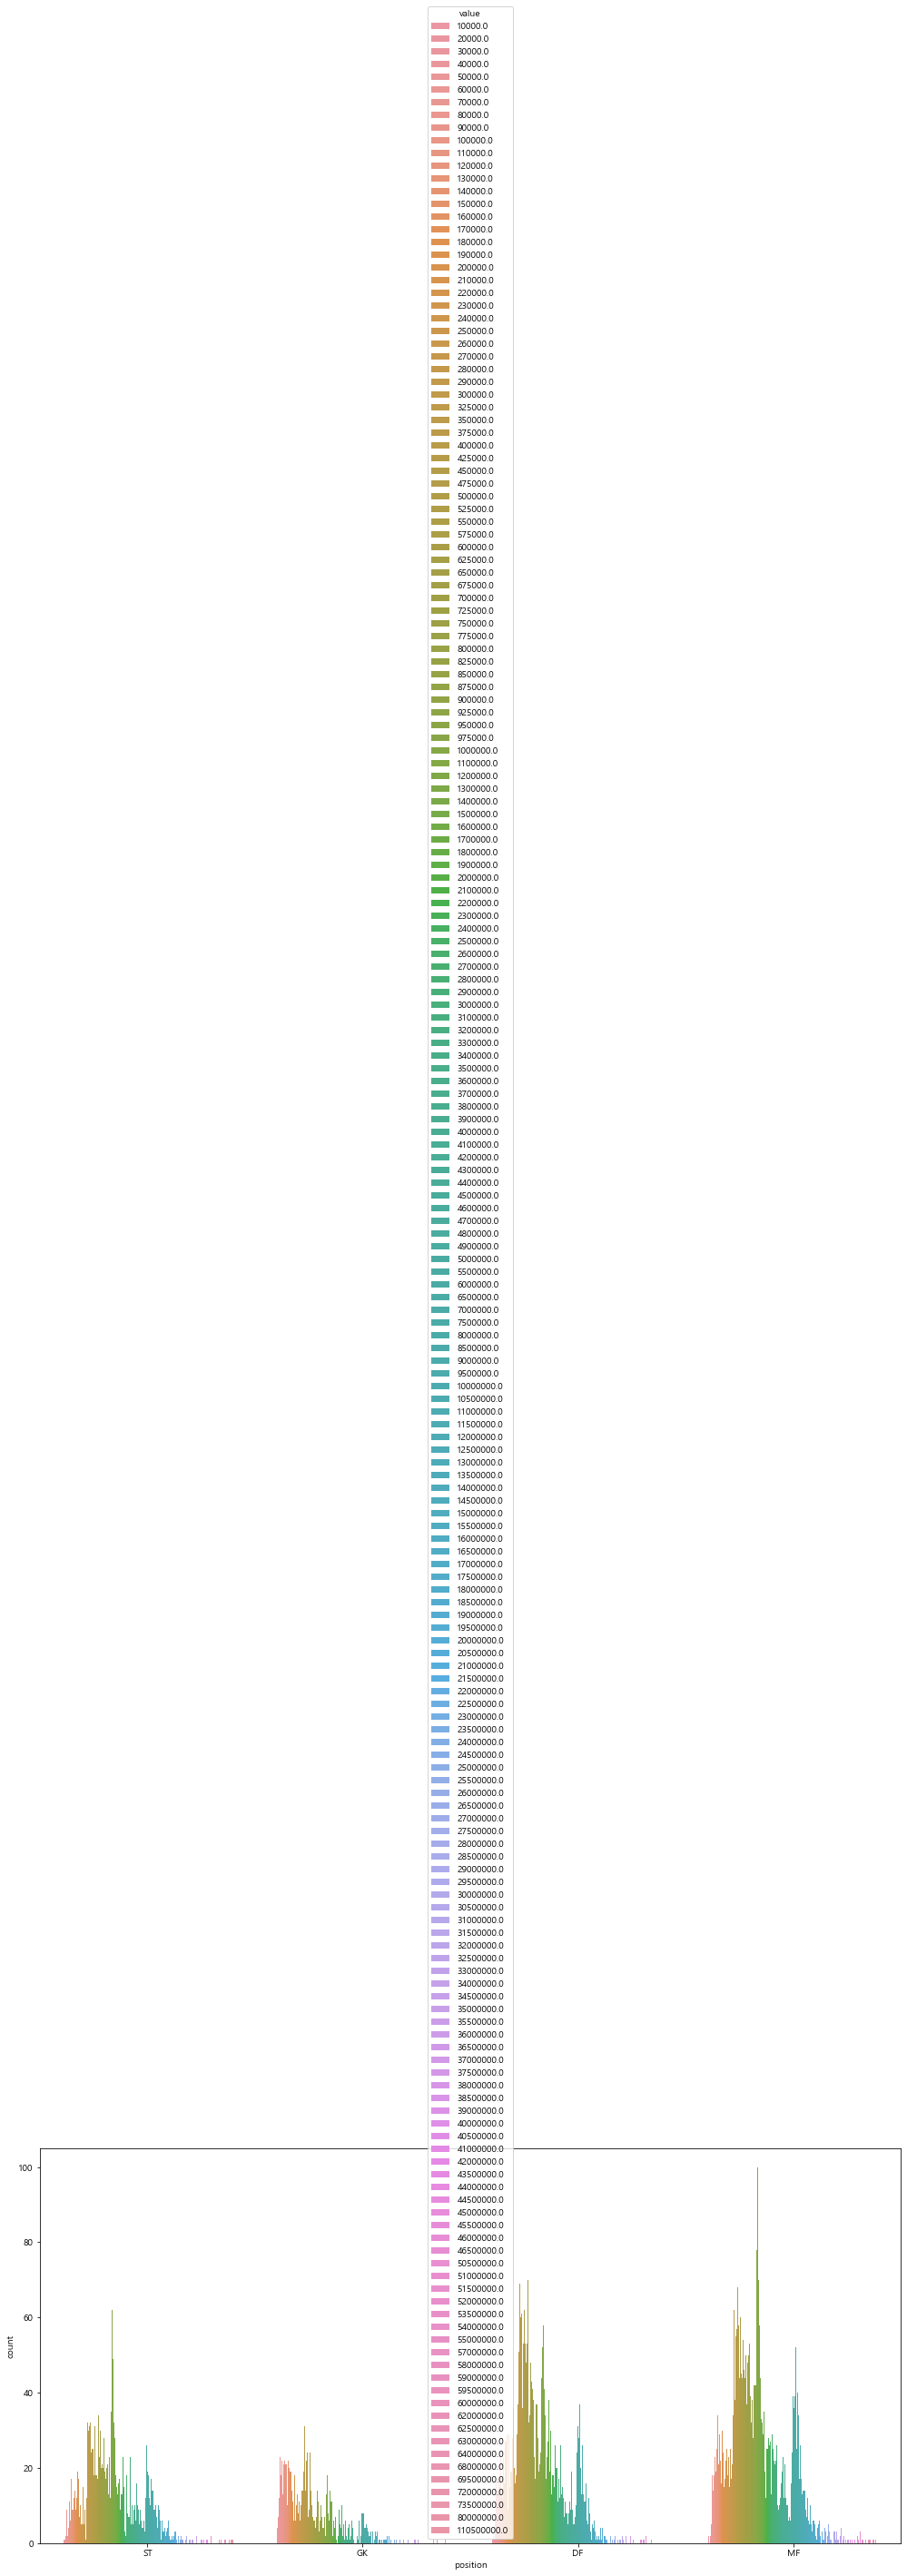

In [25]:
sns.countplot(data=train, x="position", hue="value")   # MF, DF 가 평균 연봉이 높을 것으로 판단됨

In [26]:
M1 = train[train.position == 'ST'].value.mean()  # 포지션별 평균 연봉 구하기
M2 = train[train.position == 'GK'].value.mean()
M3 = train[train.position == 'DF'].value.mean()
M4 = train[train.position == 'MF'].value.mean()
print("%.2f, %.2f, %.2f, %.2f" %(M1, M2, M3, M4))   # 결과 순서 : ST > MF > DF > GK

3330360.70, 1992073.41, 2304347.90, 3121761.96


In [27]:
train.position.value_counts()  # 포지션별 사람수

MF    3428
DF    2791
ST    1705
GK    1008
Name: position, dtype: int64

In [28]:
# 포지션별 평균 연봉 이상인 사람의 비율 구하기
M1_mean_rate =  (train[(train.position == 'ST') & (train.value >= C1)].position.count()) / 1705 * 100
M2_mean_rate =  (train[(train.position == 'GK') & (train.value >= C2)].position.count()) / 1008 * 100
M3_mean_rate =  (train[(train.position == 'DF') & (train.value >= C3)].position.count()) / 2791 * 100
M4_mean_rate =  (train[(train.position == 'MF') & (train.value >= C4)].position.count()) / 3428 * 100
print("%.2f%%, %.2f%%, %.2f%%, %.2f%%" %(M1_mean_rate, M2_mean_rate, M3_mean_rate, M4_mean_rate))
# 포지션별 연봉 평균 이상 비율이 높은순 : MF > ST > DF > GK

25.57%, 14.68%, 20.75%, 44.81%


<AxesSubplot:xlabel='prefer_foot', ylabel='count'>

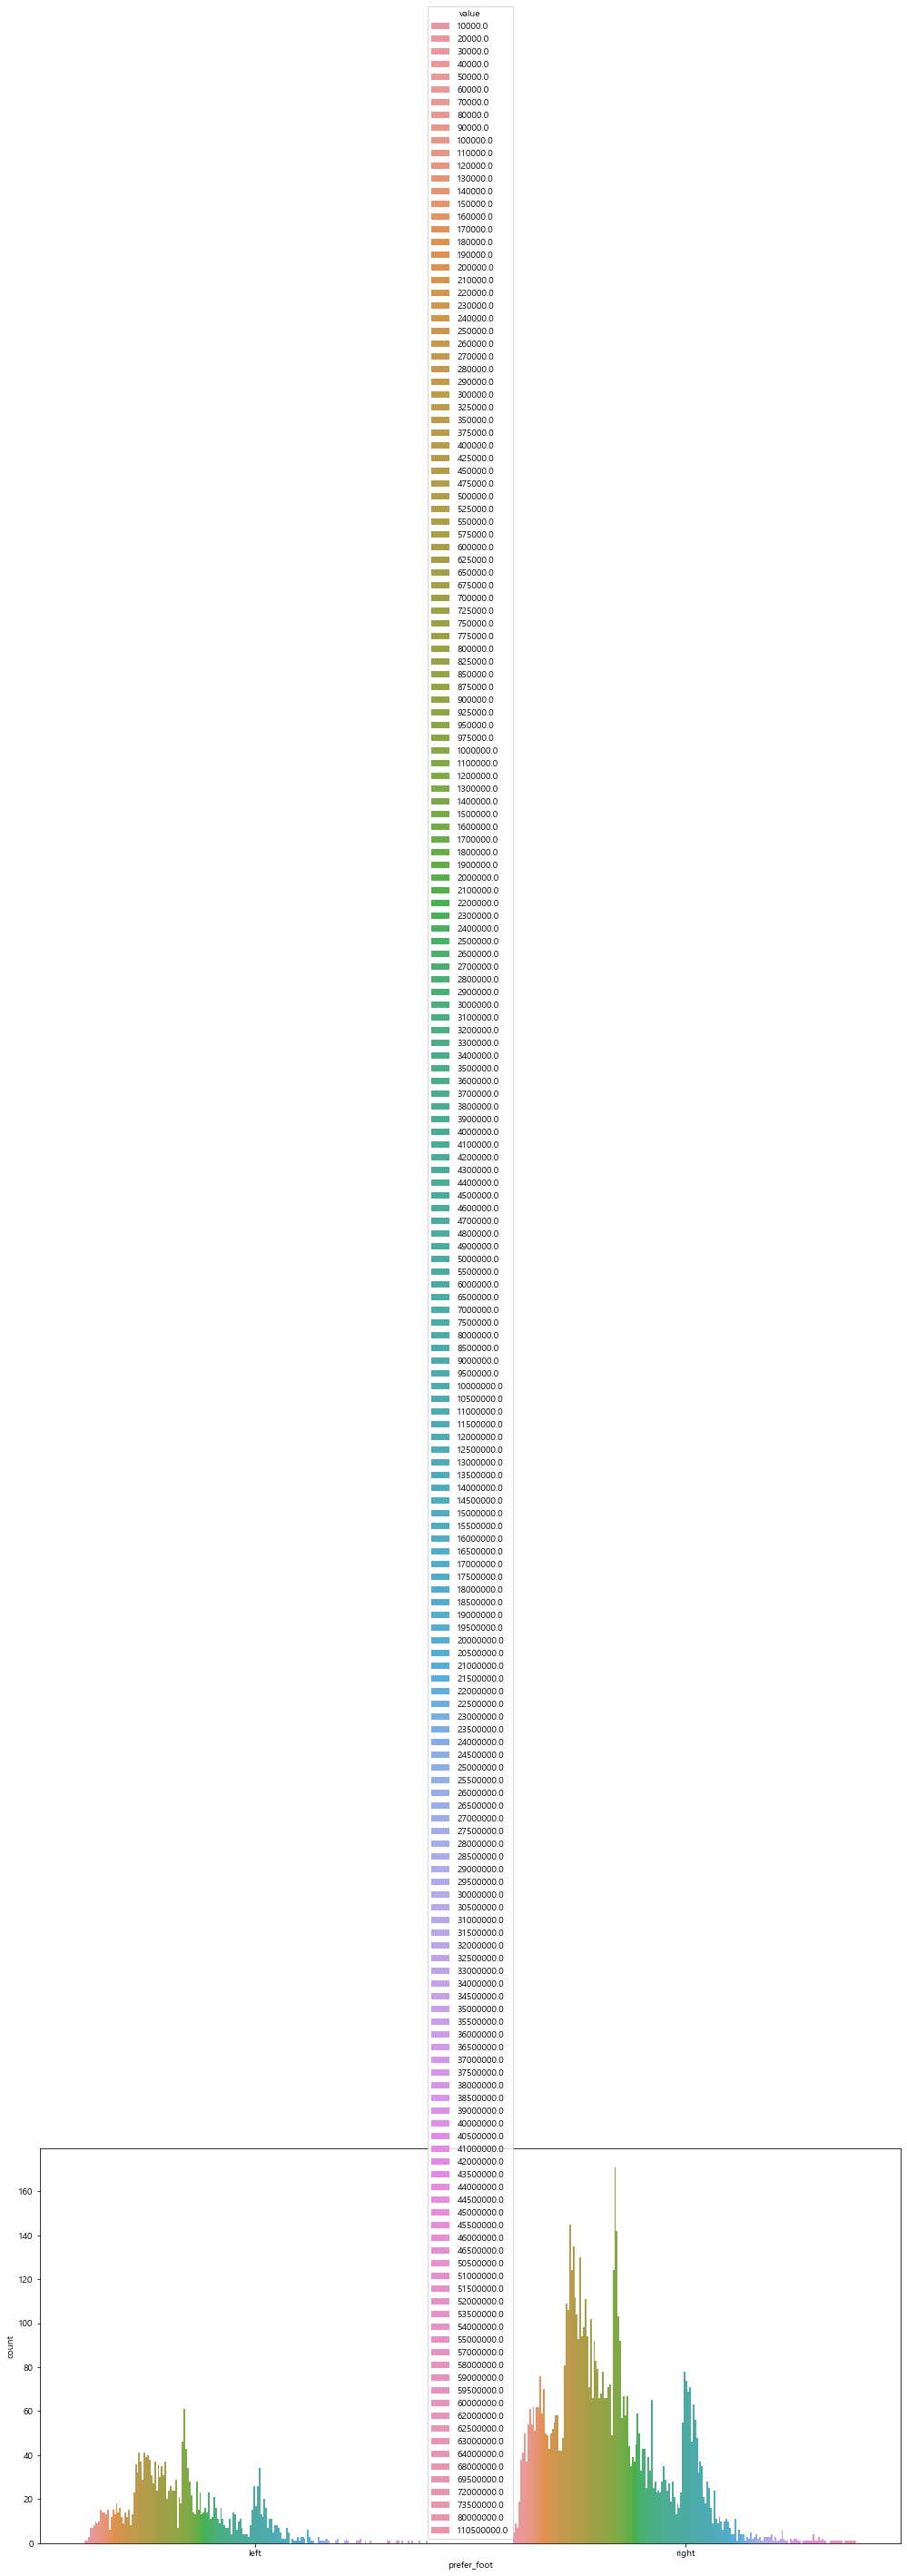

In [29]:
sns.countplot(data=train, x="prefer_foot", hue="value")   # 오른발 잡이가 수도 많고 연봉 높음

<AxesSubplot:xlabel='reputation', ylabel='count'>

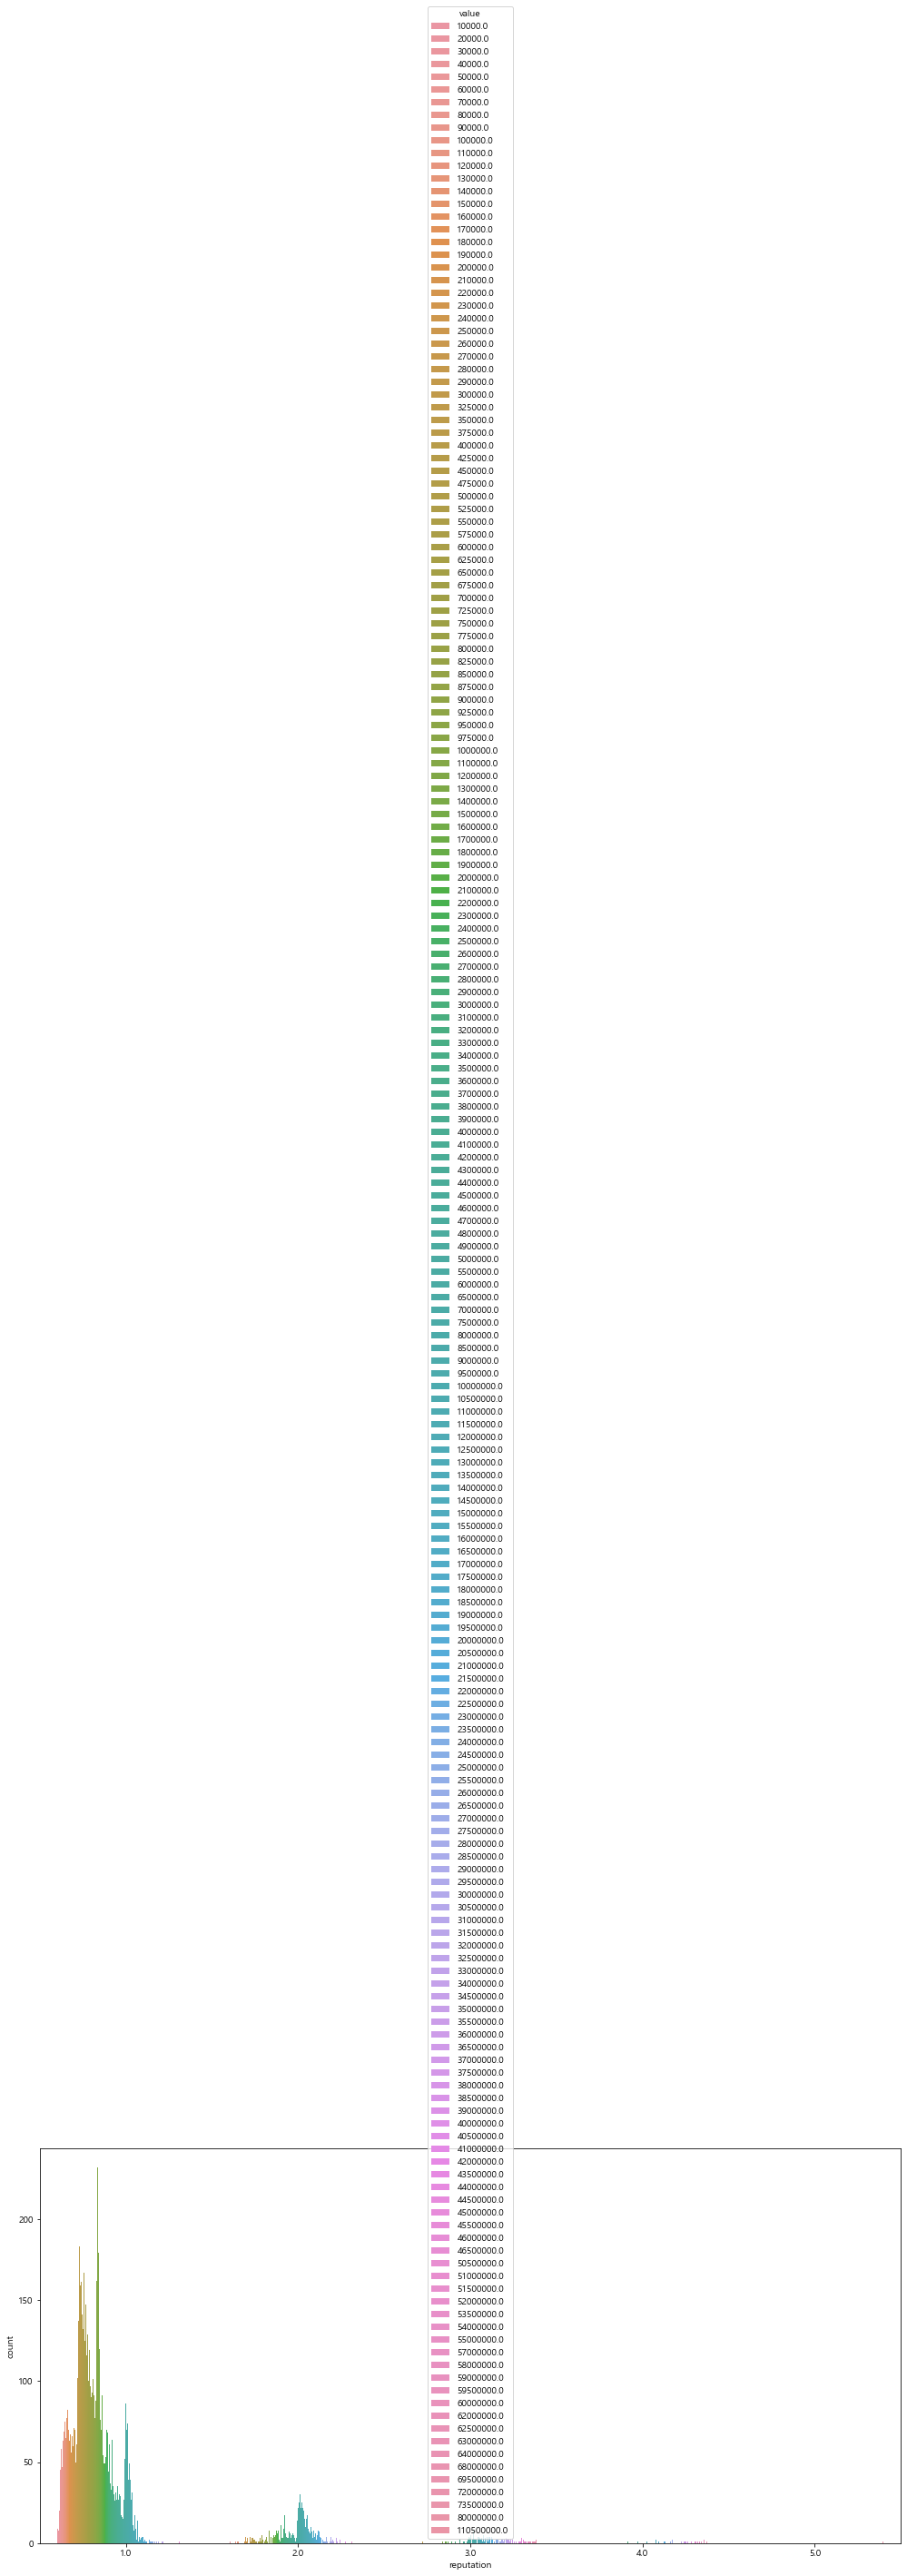

In [30]:
sns.countplot(data=train, x="reputation", hue="value") # 명성 높은 선수가 연봉 높음

<AxesSubplot:xlabel='stat_skill_moves', ylabel='count'>

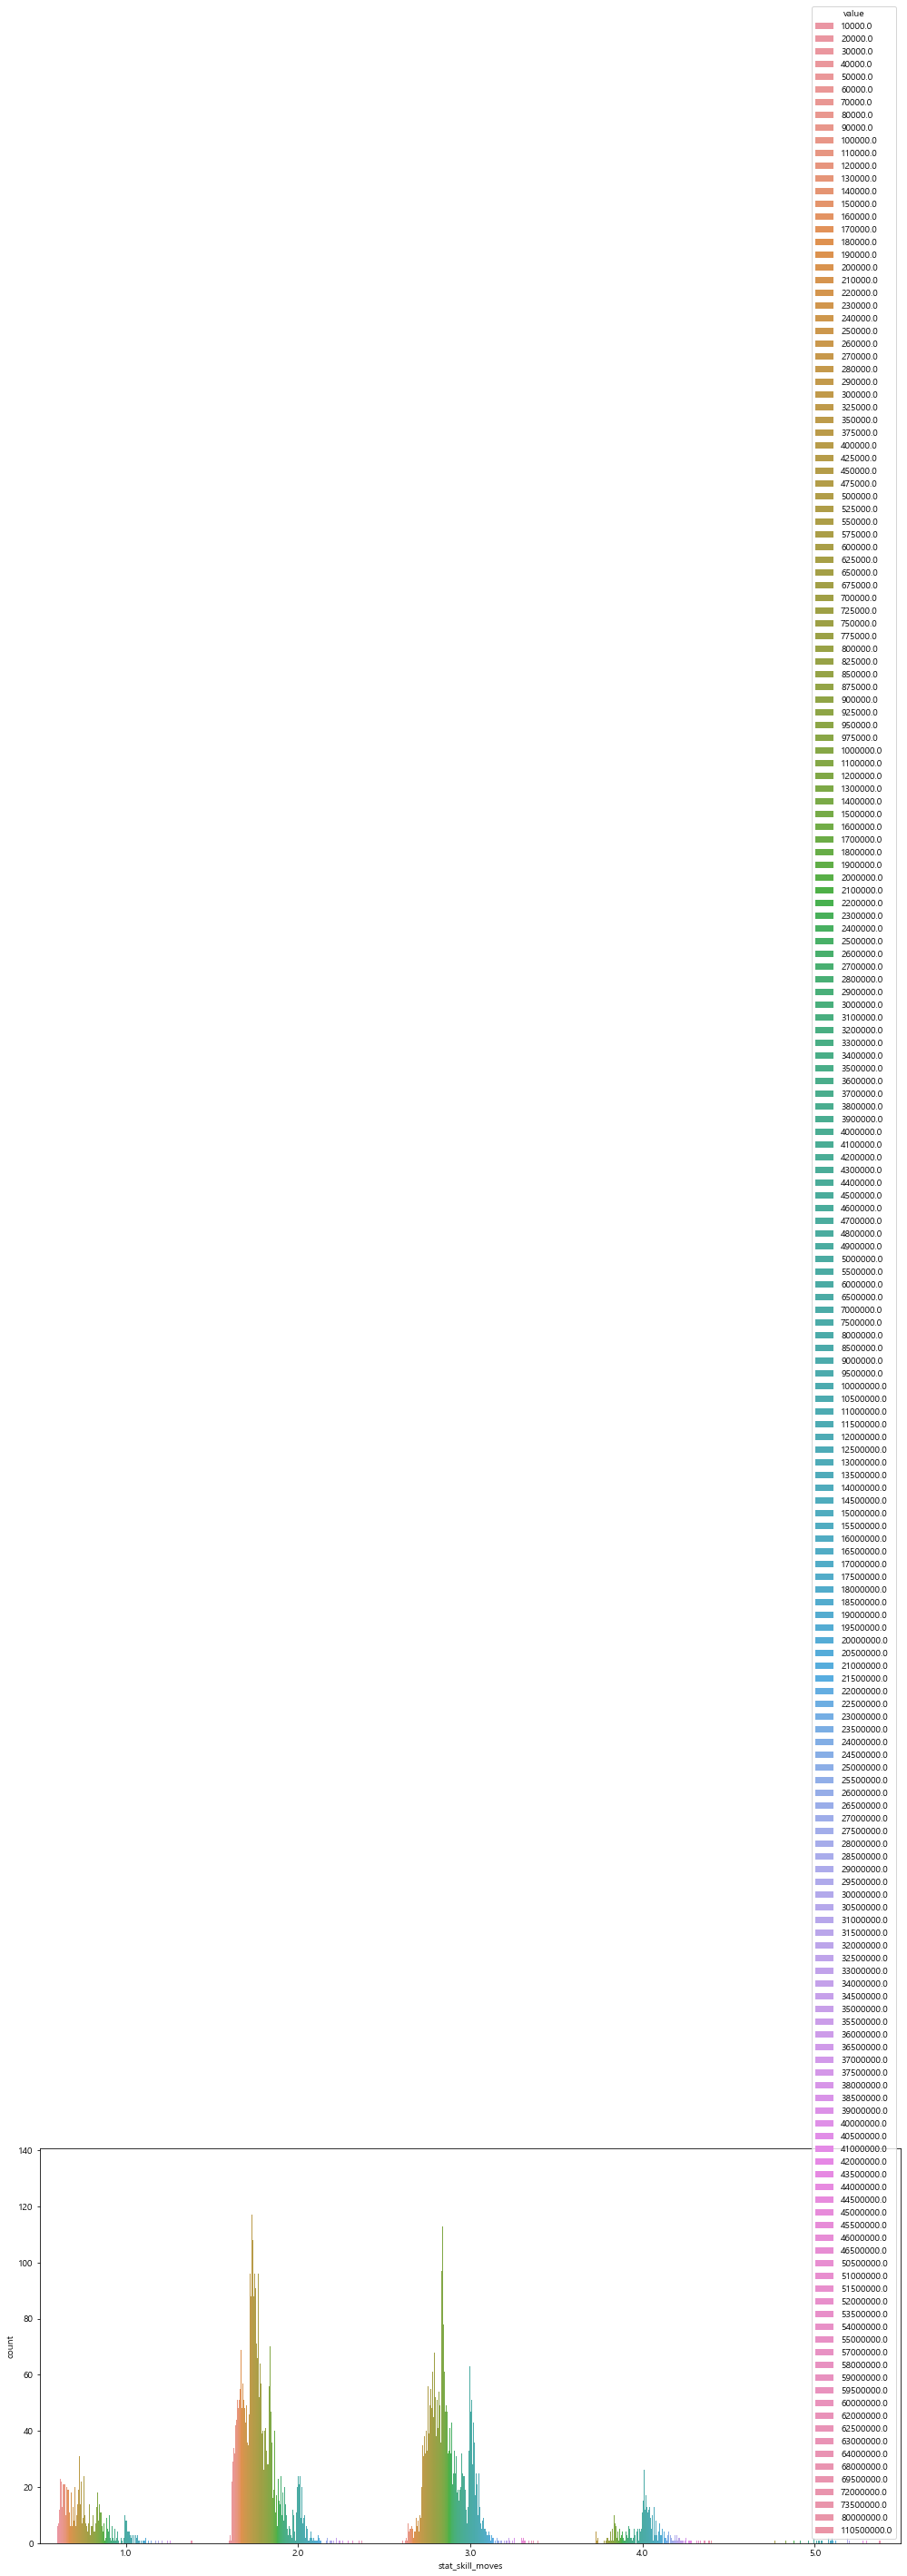

In [31]:
sns.countplot(data=train, x="stat_skill_moves", hue="value") # 명성 높은 선수가 연봉 높음

<AxesSubplot:>

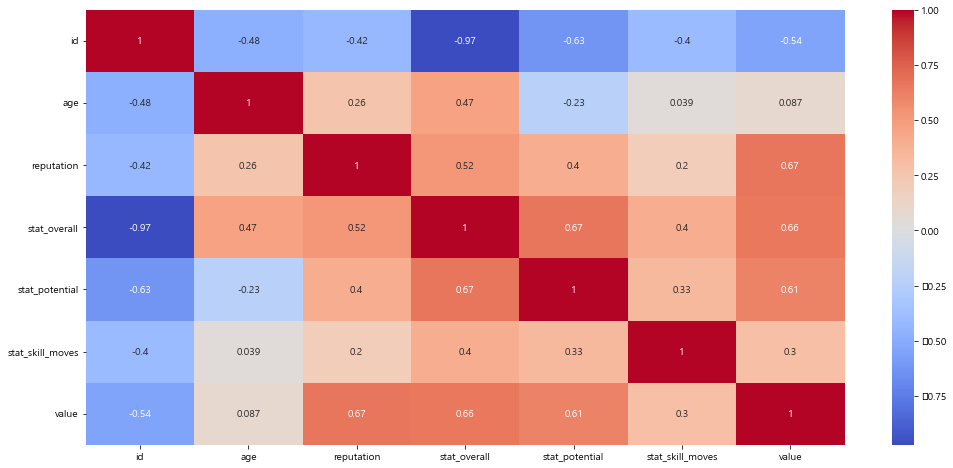

In [32]:
sns.heatmap(train.corr(), annot =True, cmap='coolwarm')   # 음 상관: 파랑, 양 상관 : 빨강, annot: 간략히 표현
# - 상관 : age, stat_skil_moves, + 상관 : reputation, start_overall
# 공분산 고려 : start_overall와 start_potential

In [33]:
# id와 name 컬럼 삭제
train.drop(['id','name'], axis =1, inplace =True)
test.drop(['id','name'], axis =1, inplace =True)

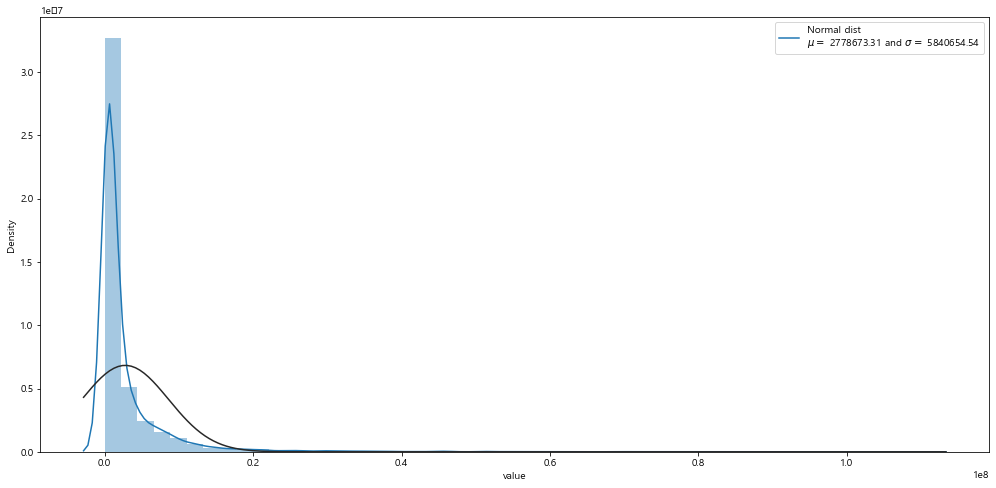

In [34]:
# y 값인 value 컬럼의 왜도 확인
sns.distplot(train.value, fit = norm)
(mu, sigma) = norm.fit(train['value'])  # 정규성 분포 fiting
plt.legend(['Normal dist\n$\mu=$ {:.2f} and $\sigma=$ {:.2f}'.format(mu, sigma)], loc = 'best')
plt.show()

In [35]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8932 entries, 0 to 8931
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   age               8932 non-null   int64  
 1   continent         8932 non-null   object 
 2   contract_until    8932 non-null   object 
 3   position          8932 non-null   object 
 4   prefer_foot       8932 non-null   object 
 5   reputation        8932 non-null   float64
 6   stat_overall      8932 non-null   int64  
 7   stat_potential    8932 non-null   int64  
 8   stat_skill_moves  8932 non-null   float64
 9   value             8932 non-null   float64
dtypes: float64(3), int64(3), object(4)
memory usage: 697.9+ KB


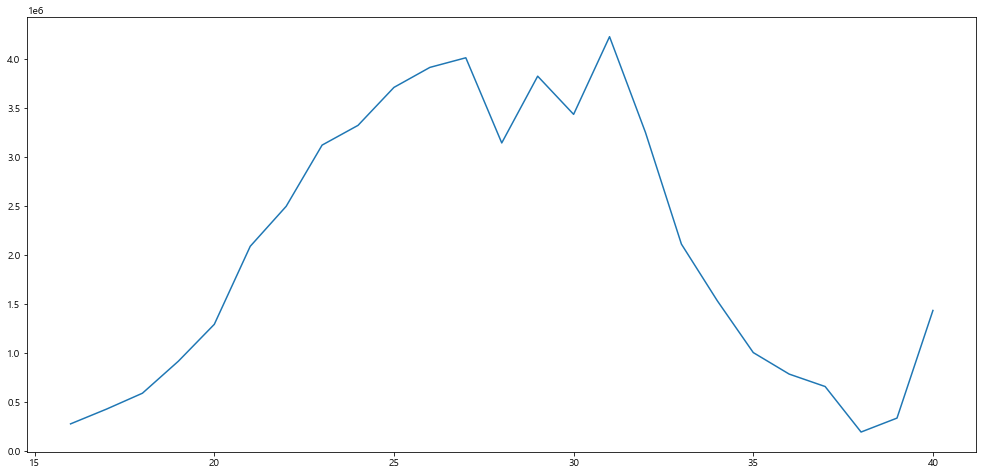

In [36]:
plt.plot(train.groupby('age').mean()['value'])

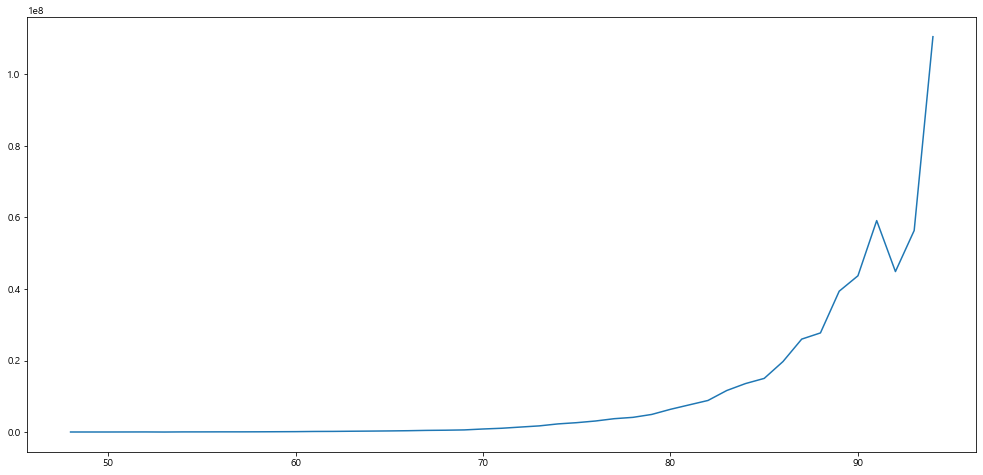

In [37]:
plt.plot(train.groupby('stat_potential').mean()['value'])

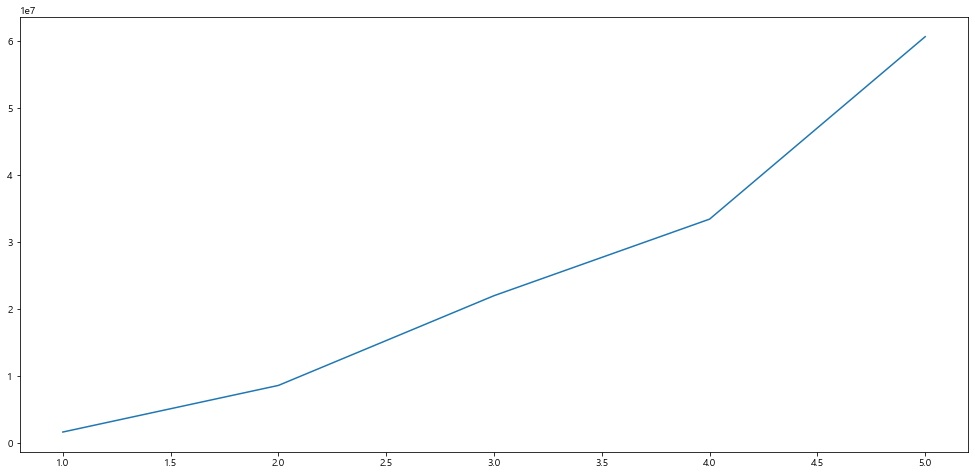

In [38]:
plt.plot(train.groupby('reputation').mean()['value'])

## feature selection

In [39]:
features = ['age','stat_skill_moves','reputation','stat_overall']
target = ['value']
# X=train_standard[features]

# - 상관 : age, stat_skil_moves, + 상관 : reputation, start_overall
# 공분산 고려 : start_overall와 start_potential

In [40]:
# from sklearn.model_selection import train_test_split
# x_train, x_test, y_train, y_test = train_test_split(features, target, train_size=0.8, random_state =31)

x_train, x_test, y_train = train[features], test[features], train[target]

## modeling

In [41]:
# Decisiontress 모델링 사용
# from sklearn.tree import DecisionTreeClassifier

# model = DecisionTreeClassifier()
# model.fit(x_train, y_train)

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(n_estimators=500)

forest.fit(x_train, y_train)

RandomForestRegressor(n_estimators=500)

In [43]:
prediction = forest.predict(x_test)

## model 평가

In [48]:
submission = submission.copy()
submission['value'] = prediction
submission

,id,value
0,1,6.977800e+07
1,2,8.051531e+07
2,4,7.091567e+07
3,5,7.091567e+07
4,6,6.169700e+07
...,...,...
3823,16924,5.238550e+04
3824,16929,5.423183e+04
3825,16932,5.958635e+04
3826,16937,5.164096e+04


In [52]:
submission.to_csv('pred.csv',index=False)

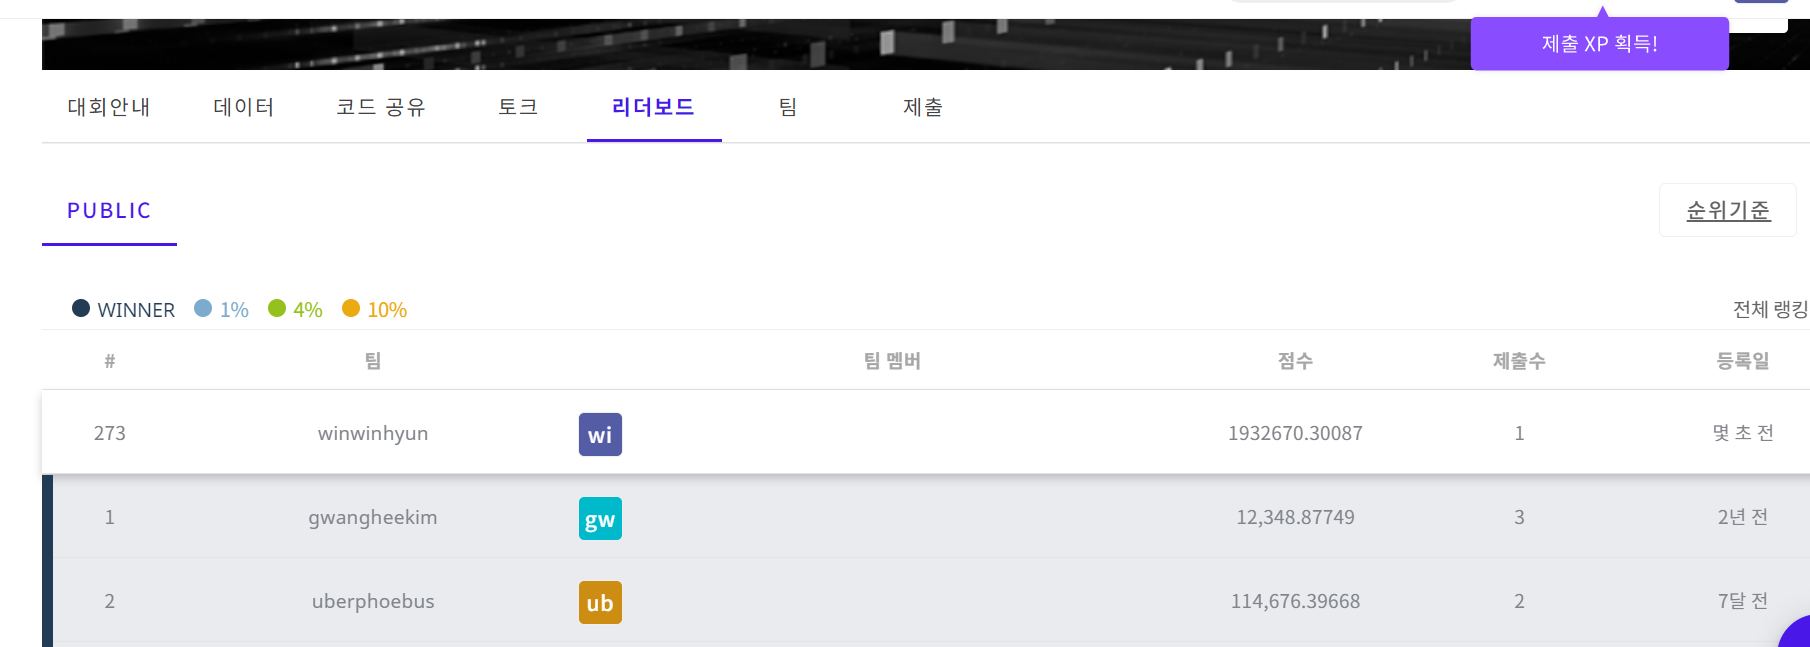

In [53]:
from IPython.display import Image
Image('11.png')

## RandomForestRegressor 모델 사용시 (273 -> 236으로 순위 변동)

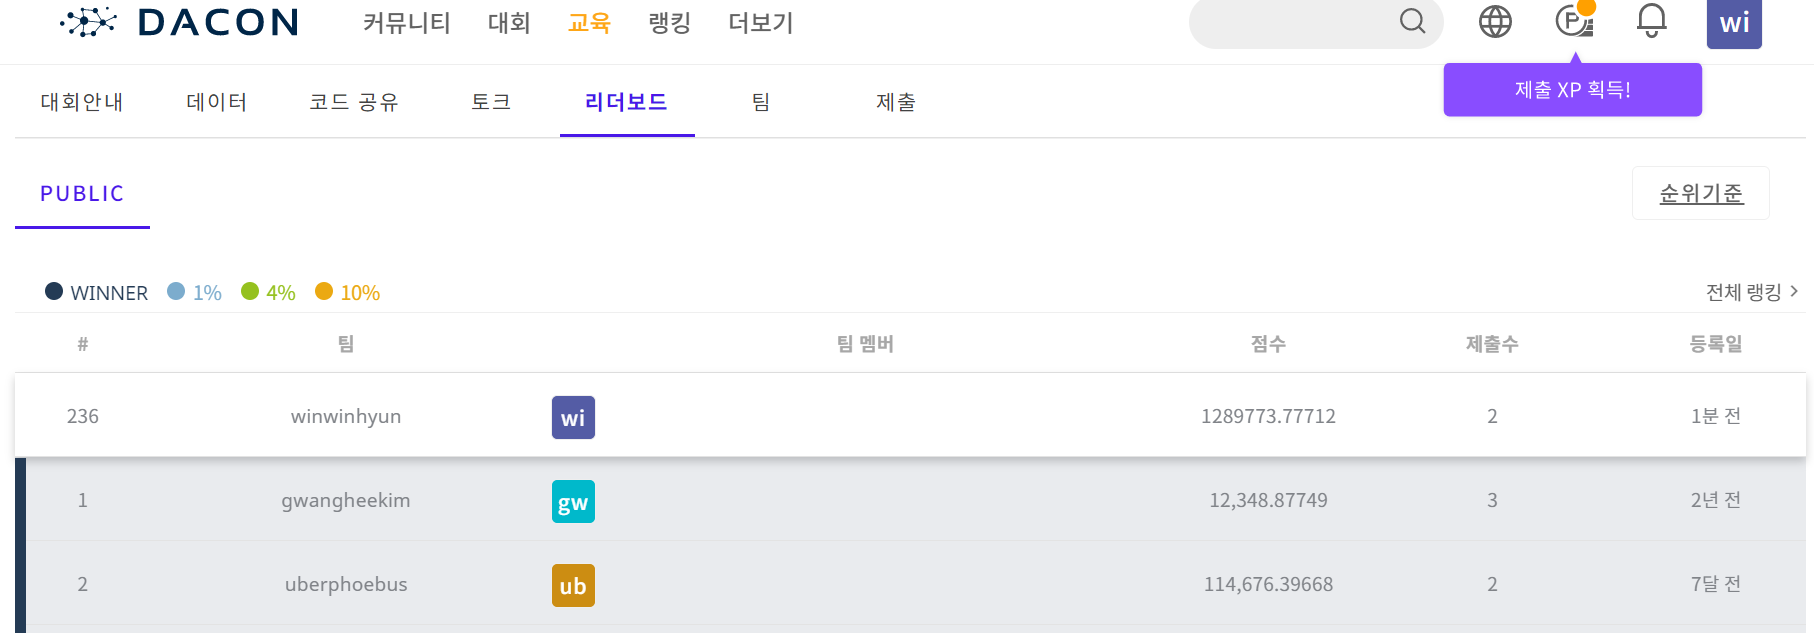

In [54]:
from IPython.display import Image
Image('111.png')